In [1]:
# !pip install -q pytorch-lightning
# !pip install -q optuna
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import pytorch_lightning as pl
import seaborn as sns
import torch
import torch.nn as nn
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PowerTransformer
from torch.utils.data import DataLoader, TensorDataset
from torchmetrics import Accuracy, MetricCollection

/home/ksterx/miniconda3/envs/ai/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# !wget https://raw.githubusercontent.com/UTDataMining/2022A/master/project/winequality-white.csv

In [3]:
wine = pd.read_csv("winequality-white.csv", sep=";")

array([[<AxesSubplot: title={'center': 'fixed acidity'}>,
        <AxesSubplot: title={'center': 'volatile acidity'}>,
        <AxesSubplot: title={'center': 'citric acid'}>],
       [<AxesSubplot: title={'center': 'residual sugar'}>,
        <AxesSubplot: title={'center': 'chlorides'}>,
        <AxesSubplot: title={'center': 'free sulfur dioxide'}>],
       [<AxesSubplot: title={'center': 'total sulfur dioxide'}>,
        <AxesSubplot: title={'center': 'density'}>,
        <AxesSubplot: title={'center': 'pH'}>],
       [<AxesSubplot: title={'center': 'sulphates'}>,
        <AxesSubplot: title={'center': 'alcohol'}>,
        <AxesSubplot: title={'center': 'quality'}>]], dtype=object)

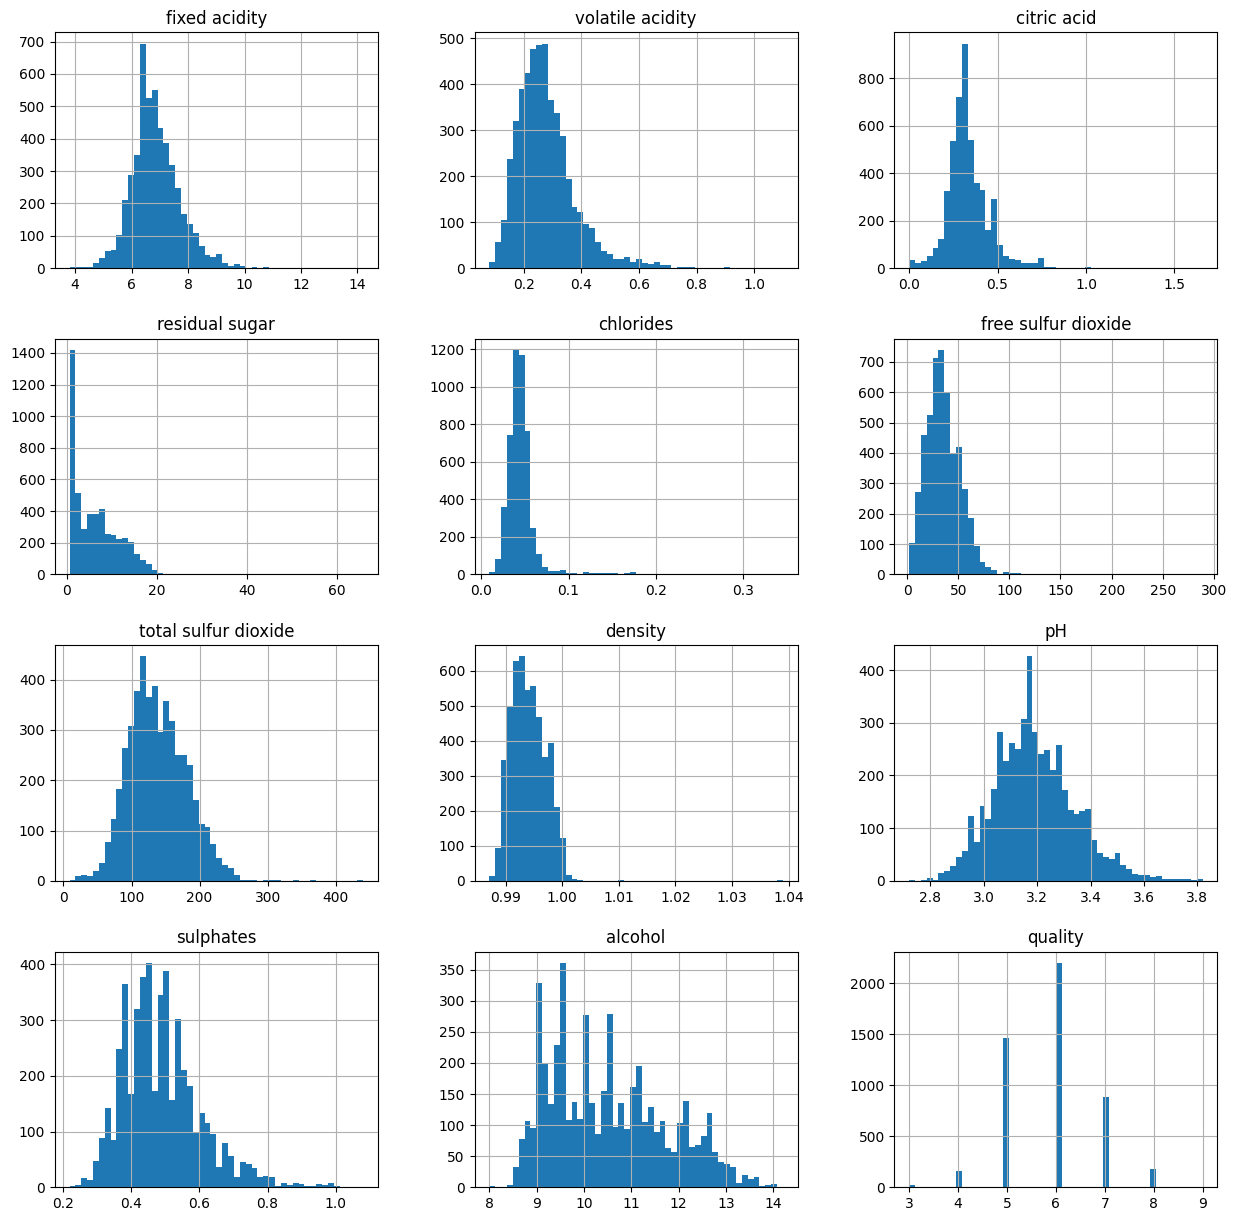

In [4]:
wine.hist(bins=50, figsize=(15, 15))

In [5]:
wine.corr(method="pearson")

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,1.000000,-0.022697,0.289181,0.089021,0.023086,-0.049396,0.091070,0.265331,-0.425858,-0.017143,-0.120881,-0.113663
volatile acidity,-0.022697,1.000000,-0.149472,0.064286,0.070512,-0.097012,0.089261,0.027114,-0.031915,-0.035728,0.067718,-0.194723
citric acid,0.289181,-0.149472,1.000000,0.094212,0.114364,0.094077,0.121131,0.149503,-0.163748,0.062331,-0.075729,-0.009209
residual sugar,0.089021,0.064286,0.094212,1.000000,0.088685,0.299098,0.401439,0.838966,-0.194133,-0.026664,-0.450631,-0.097577
chlorides,0.023086,0.070512,0.114364,0.088685,1.000000,0.101392,0.198910,0.257211,-0.090439,0.016763,-0.360189,-0.209934
free sulfur dioxide,-0.049396,-0.097012,0.094077,0.299098,0.101392,1.000000,0.615501,0.294210,-0.000618,0.059217,-0.250104,0.008158
total sulfur dioxide,0.091070,0.089261,0.121131,0.401439,0.198910,0.615501,1.000000,0.529881,0.002321,0.134562,-0.448892,-0.174737
density,0.265331,0.027114,0.149503,0.838966,0.257211,0.294210,0.529881,1.000000,-0.093591,0.074493,-0.780138,-0.307123
pH,-0.425858,-0.031915,-0.163748,-0.194133,-0.090439,-0.000618,0.002321,-0.093591,1.000000,0.155951,0.121432,0.099427
sulphates,-0.017143,-0.035728,0.062331,-0.026664,0.016763,0.059217,0.134562,0.074493,0.155951,1.000000,-0.017433,0.053678


In [6]:
X = wine[
    [
        "fixed acidity",
        "volatile acidity",
        "citric acid",
        "residual sugar",
        "chlorides",
        "free sulfur dioxide",
        "total sulfur dioxide",
        "density",
        "pH",
        "sulphates",
        "alcohol",
    ]
].values

y = wine["quality"].values
y = (y >= 6).astype(int)
print(np.sum(y == 1, axis=0))
print(np.sum(y == 0, axis=0))

3258
1640


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [8]:
lr = LogisticRegression(solver="liblinear", multi_class="auto")
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(f1_score(y_test, y_pred))

[[158 170]
 [ 76 576]]
0.7489795918367347
0.7721179624664879
0.8834355828220859
0.8240343347639485


In [9]:
class WineModel(pl.LightningModule):
    NUM_FEATURES = 11
    OUTPUT_SIZE = 2

    def __init__(self, hidden_size, lr, l2_lambda):
        super().__init__()
        self.lr = lr
        self.l2_lambda = l2_lambda

        self.loss_fn = nn.CrossEntropyLoss()
        metrics = MetricCollection([Accuracy(task="multiclass", num_classes=2)])
        self.train_metrics = metrics.clone(prefix="train_")
        self.val_metrics = metrics.clone(prefix="val_")

        # sequential model with batch normalization
        self.net = nn.Sequential(
            nn.Linear(self.NUM_FEATURES, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, self.OUTPUT_SIZE),
        )

    def forward(self, x):
        return self.net(x.to(torch.float32))

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=self.l2_lambda)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=5)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_epoch_loss"}

    def training_step(self, batch, batch_index):
        x, target = batch
        pred = self(x)
        loss = self.loss_fn(pred, target)
        self.train_metrics(pred, target)
        self.log("train_loss", loss, prog_bar=True, logger=True, on_step=True, on_epoch=True, sync_dist=True)
        self.log_dict(self.train_metrics, prog_bar=False, logger=True, on_step=True, on_epoch=True, sync_dist=True)
        return {
            "loss": loss,
            "target": target,
            "pred": pred,
        }

    def validation_step(self, batch, batch_index):
        x, target = batch
        pred = self(x)
        loss = self.loss_fn(pred, target)
        self.val_metrics(pred, target)
        self.log("val_loss", loss, prog_bar=True, logger=True, on_step=True, on_epoch=False, sync_dist=True)
        self.log_dict(self.val_metrics, prog_bar=False, logger=True, on_step=True, on_epoch=True, sync_dist=True)
        return {
            "loss": loss,
            "target": target,
            "pred": pred,
        }

    def training_epoch_end(self, outputs):
        avg_loss = torch.stack([x["loss"] for x in outputs]).mean()
        self.log("train_epoch_loss", avg_loss, prog_bar=True, logger=True, on_step=False, on_epoch=True, sync_dist=True)

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x["loss"] for x in outputs]).mean()
        self.log("val_epoch_loss", avg_loss, prog_bar=True, logger=True, on_step=False, on_epoch=True, sync_dist=True)


In [10]:
class WineData(pl.LightningDataModule):
    FEATURES = [
        "fixed acidity",
        "volatile acidity",
        "citric acid",
        "residual sugar",
        "chlorides",
        "free sulfur dioxide",
        "total sulfur dioxide",
        "density",
        "pH",
        "sulphates",
        "alcohol",
    ]

    def __init__(self, batch_size, X_train, X_test, y_train, y_test, iqr_thresholds, remove_outliers=True, viz=False):
        super().__init__()

        self.X_train = X_train
        self.batch_size = batch_size
        self.iqr_thresholds = iqr_thresholds
        self.remove_outliers = remove_outliers

        if viz:
            self._plot(X_train, "Before preprocessing")

        # Preprocess data
        self.pt = PowerTransformer()
        X_train_7 = X_train[:, 7]
        X_test_7 = X_test[:, 7]
        self.X_train_yj = self.pt.fit_transform(X_train)
        self.X_test_yj = self.pt.transform(X_test)
        self.X_train_yj[:, 7] = X_train_7  # density (affected by outliers)
        self.X_test_yj[:, 7] = X_test_7  # density (affected by outliers)

        if viz:
            self._plot(self.X_train_yj, "After yeo-johnson transformation")
        
        if remove_outliers:
            self.X_train_yj, y_train = self._remove_outliers(self.X_train_yj, y_train)

        self.scaler = StandardScaler()
        X_train_norm = self.scaler.fit_transform(self.X_train_yj)
        X_test_norm = self.scaler.transform(self.X_test_yj)

        if viz:
            self._plot(X_train_norm, "After normalization")

        self.X_train_norm = torch.from_numpy(X_train_norm)
        self.X_test_norm = torch.from_numpy(X_test_norm)
        self.y_train = torch.from_numpy(y_train)
        self.y_test = torch.from_numpy(y_test)

        self.train_dataset = TensorDataset(self.X_train_norm, self.y_train)
        self.test_dataset = TensorDataset(self.X_test_norm, self.y_test)

    def _remove_outliers(self, x: np.ndarray, y):
        # (iqr_threshold) iqr or higher
        q1 = np.quantile(x, 0.25, axis=0)
        q3 = np.quantile(x, 0.75, axis=0)
        iqr = q3 - q1
        self.lower = q1 - self.iqr_thresholds * iqr
        self.upper = q3 + self.iqr_thresholds * iqr
        mask = (x < self.lower) | (x > self.upper)
        mask = mask.any(axis=1)
        x = x[~mask]
        y = y[~mask]
        return x, y

    def plot(self):
        fig, ax = plt.subplots(4, 3, figsize=(15, 15))
        mean = self.X_train_yj.mean(axis=0)
        for i in range(len(self.FEATURES)):
            sns.histplot(self.X_train_yj[:, i], ax=ax[i // 3, i % 3])
            ax[i // 3, i % 3].axvline(mean[i], color="yellow")
            if i != 3 and self.remove_outliers:
                ax[i // 3, i % 3].axvline(self.lower[i], color="red")
                ax[i // 3, i % 3].axvline(self.upper[i], color="red")
            ax[i // 3, i % 3].set_title(f"{self.FEATURES[i]}")
        plt.show()

    def _plot(self, x, fig_name, y=None):
        fig, ax = plt.subplots(4, 3, figsize=(15, 15))
        for i in range(len(self.FEATURES)):
            sns.histplot(x[:, i], ax=ax[i // 3, i % 3])
            if y is not None:
                sns.histplot(y[:, i], ax=ax[i // 3, i % 3])
            ax[i // 3, i % 3].set_title(f"{self.FEATURES[i]}")
        fig.suptitle(fig_name)
        plt.show()

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=8, drop_last=True)

    def val_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=8, drop_last=True)


In [11]:
# Hyperparameters
epochs = 100
lr = 1e-4
hidden_size = 1000
batch_size = 32
seed = 22

In [12]:
def objective(trial):
    iqr_threshold = trial.suggest_float("iqr_threshold", 2.5, 5)
    iqr_thresholds = np.ones(11) * iqr_threshold
    l2_lambda = trial.suggest_float("l2_lambda", 1e-6, 1e-4, log=True)

    data = WineData(
        batch_size=batch_size,
        X_train=X_train,
        X_test=X_test,
        y_train=y_train,
        y_test=y_test,
        iqr_thresholds=iqr_thresholds,
    )
    model = WineModel(hidden_size=hidden_size, lr=lr, l2_lambda=l2_lambda)
    logger = TensorBoardLogger("logs", name="wine")
    monitor = "val_MulticlassAccuracy_epoch"
    early_stopping = EarlyStopping(monitor=monitor, mode="max", patience=5)
    model_checkpoint = ModelCheckpoint(monitor=monitor, mode="max", save_top_k=3, save_last=True)
    trainer = pl.Trainer(
        max_epochs=epochs,
        logger=logger,
        callbacks=[early_stopping, model_checkpoint],
        accelerator="cuda",
        devices=1,
    )
    trainer.fit(model, data)
    return trainer.checkpoint_callback.best_model_score.item()

In [13]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)
print(study.best_params)
print(study.best_value)

[I 2023-01-13 19:59:50,476] A new study created in memory with name: no-name-c4d41342-ab3f-49cb-940a-e3a8ebcbf987
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 152/152 [00:01<00:00, 145.26it/s, loss=0.405, v_num=288, train_loss_step=0.436, val_loss=0.672, val_epoch_loss=0.466, train_loss_epoch=0.399, train_epoch_loss=0.399]

[I 2023-01-13 20:00:01,524] Trial 0 finished with value: 0.793749988079071 and parameters: {'iqr_threshold': 4.150056878790051, 'l2_lambda': 9.73740520765566e-05}. Best is trial 0 with value: 0.793749988079071.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)


Epoch 7: 100%|██████████| 152/152 [00:01<00:00, 145.32it/s, loss=0.439, v_num=289, train_loss_step=0.474, val_loss=0.662, val_epoch_loss=0.467, train_loss_epoch=0.407, train_epoch_loss=0.407]


[I 2023-01-13 20:00:09,986] Trial 1 finished with value: 0.7947916388511658 and parameters: {'iqr_threshold': 4.907031560425752, 'l2_lambda': 2.4186695064992848e-06}. Best is trial 1 with value: 0.7947916388511658.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)


Epoch 11: 100%|██████████| 152/152 [00:01<00:00, 129.71it/s, loss=0.38, v_num=290, train_loss_step=0.372, val_loss=0.646, val_epoch_loss=0.469, train_loss_epoch=0.384, train_epoch_loss=0.384] 


[I 2023-01-13 20:00:23,121] Trial 2 finished with value: 0.7989583611488342 and parameters: {'iqr_threshold': 3.559250417580723, 'l2_lambda': 1.7421353901993497e-05}. Best is trial 2 with value: 0.7989583611488342.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 151/151 [00:01<00:00, 139.54it/s, loss=0.415, v_num=291, train_loss_step=0.534, val_loss=0.688, val_epoch_loss=0.472, train_loss_epoch=0.398, train_epoch_loss=0.398]


[I 2023-01-13 20:00:34,244] Trial 3 finished with value: 0.7979166507720947 and parameters: {'iqr_threshold': 3.192525823131911, 'l2_lambda': 4.591195952984482e-06}. Best is trial 2 with value: 0.7989583611488342.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)


Epoch 11: 100%|██████████| 152/152 [00:01<00:00, 134.80it/s, loss=0.407, v_num=292, train_loss_step=0.294, val_loss=0.586, val_epoch_loss=0.476, train_loss_epoch=0.392, train_epoch_loss=0.392]


[I 2023-01-13 20:00:47,612] Trial 4 finished with value: 0.7979166507720947 and parameters: {'iqr_threshold': 3.4133344605133553, 'l2_lambda': 4.833084303742655e-05}. Best is trial 2 with value: 0.7989583611488342.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 152/152 [00:01<00:00, 147.79it/s, loss=0.371, v_num=293, train_loss_step=0.450, val_loss=0.649, val_epoch_loss=0.470, train_loss_epoch=0.401, train_epoch_loss=0.401]


[I 2023-01-13 20:00:58,851] Trial 5 finished with value: 0.7906249761581421 and parameters: {'iqr_threshold': 4.619951215859485, 'l2_lambda': 6.586921611818568e-06}. Best is trial 2 with value: 0.7989583611488342.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)


Epoch 6: 100%|██████████| 152/152 [00:01<00:00, 140.97it/s, loss=0.425, v_num=294, train_loss_step=0.475, val_loss=0.568, val_epoch_loss=0.461, train_loss_epoch=0.423, train_epoch_loss=0.423]


[I 2023-01-13 20:01:06,876] Trial 6 finished with value: 0.7885416746139526 and parameters: {'iqr_threshold': 4.050729662077303, 'l2_lambda': 1.3241393568194098e-05}. Best is trial 2 with value: 0.7989583611488342.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)


Epoch 6: 100%|██████████| 151/151 [00:01<00:00, 135.67it/s, loss=0.448, v_num=295, train_loss_step=0.439, val_loss=0.671, val_epoch_loss=0.470, train_loss_epoch=0.420, train_epoch_loss=0.420]


[I 2023-01-13 20:01:14,694] Trial 7 finished with value: 0.7906249761581421 and parameters: {'iqr_threshold': 3.1664311136661976, 'l2_lambda': 2.3385321671827355e-06}. Best is trial 2 with value: 0.7989583611488342.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)


Epoch 10: 100%|██████████| 152/152 [00:01<00:00, 103.52it/s, loss=0.41, v_num=296, train_loss_step=0.706, val_loss=0.595, val_epoch_loss=0.472, train_loss_epoch=0.396, train_epoch_loss=0.396] 

[I 2023-01-13 20:01:29,230] Trial 8 finished with value: 0.7927083373069763 and parameters: {'iqr_threshold': 4.104168641996734, 'l2_lambda': 1.5477708270132205e-06}. Best is trial 2 with value: 0.7989583611488342.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)



Epoch 15: 100%|██████████| 152/152 [00:01<00:00, 143.18it/s, loss=0.363, v_num=297, train_loss_step=0.616, val_loss=0.671, val_epoch_loss=0.472, train_loss_epoch=0.368, train_epoch_loss=0.368]


[I 2023-01-13 20:01:50,336] Trial 9 finished with value: 0.7927083373069763 and parameters: {'iqr_threshold': 4.40251610679243, 'l2_lambda': 4.27017925643415e-06}. Best is trial 2 with value: 0.7989583611488342.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)


Epoch 17: 100%|██████████| 150/150 [00:01<00:00, 145.56it/s, loss=0.358, v_num=298, train_loss_step=0.311, val_loss=0.713, val_epoch_loss=0.479, train_loss_epoch=0.360, train_epoch_loss=0.360]


[I 2023-01-13 20:02:10,210] Trial 10 finished with value: 0.8010416626930237 and parameters: {'iqr_threshold': 2.5777354786572806, 'l2_lambda': 1.9627055443226216e-05}. Best is trial 10 with value: 0.8010416626930237.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)


Epoch 14: 100%|██████████| 150/150 [00:01<00:00, 134.92it/s, loss=0.388, v_num=299, train_loss_step=0.616, val_loss=0.645, val_epoch_loss=0.486, train_loss_epoch=0.377, train_epoch_loss=0.377]


[I 2023-01-13 20:02:27,037] Trial 11 finished with value: 0.796875 and parameters: {'iqr_threshold': 2.50231564235932, 'l2_lambda': 1.7918573821280196e-05}. Best is trial 10 with value: 0.8010416626930237.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 150/150 [00:01<00:00, 139.66it/s, loss=0.431, v_num=300, train_loss_step=0.527, val_loss=0.616, val_epoch_loss=0.462, train_loss_epoch=0.398, train_epoch_loss=0.398]


[I 2023-01-13 20:02:38,507] Trial 12 finished with value: 0.7822916507720947 and parameters: {'iqr_threshold': 2.535383024138161, 'l2_lambda': 2.8569286678154845e-05}. Best is trial 10 with value: 0.8010416626930237.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)


Epoch 7: 100%|██████████| 151/151 [00:01<00:00, 130.38it/s, loss=0.438, v_num=301, train_loss_step=0.346, val_loss=0.679, val_epoch_loss=0.466, train_loss_epoch=0.409, train_epoch_loss=0.409]


[I 2023-01-13 20:02:47,907] Trial 13 finished with value: 0.7947916388511658 and parameters: {'iqr_threshold': 2.877495111879352, 'l2_lambda': 2.9524825164059668e-05}. Best is trial 10 with value: 0.8010416626930237.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)


Epoch 8: 100%|██████████| 152/152 [00:01<00:00, 136.47it/s, loss=0.406, v_num=302, train_loss_step=0.556, val_loss=0.666, val_epoch_loss=0.463, train_loss_epoch=0.411, train_epoch_loss=0.411]


[I 2023-01-13 20:02:58,430] Trial 14 finished with value: 0.7895833253860474 and parameters: {'iqr_threshold': 3.464502243430047, 'l2_lambda': 1.0290023455155388e-05}. Best is trial 10 with value: 0.8010416626930237.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)


Epoch 10: 100%|██████████| 152/152 [00:01<00:00, 136.29it/s, loss=0.381, v_num=303, train_loss_step=0.372, val_loss=0.649, val_epoch_loss=0.468, train_loss_epoch=0.390, train_epoch_loss=0.390]


[I 2023-01-13 20:03:11,232] Trial 15 finished with value: 0.7906249761581421 and parameters: {'iqr_threshold': 3.6429325622172652, 'l2_lambda': 2.135933065243029e-05}. Best is trial 10 with value: 0.8010416626930237.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)


Epoch 14: 100%|██████████| 151/151 [00:01<00:00, 133.05it/s, loss=0.398, v_num=304, train_loss_step=0.341, val_loss=0.614, val_epoch_loss=0.445, train_loss_epoch=0.372, train_epoch_loss=0.372]


[I 2023-01-13 20:03:28,189] Trial 16 finished with value: 0.8125 and parameters: {'iqr_threshold': 2.86548313896768, 'l2_lambda': 4.845372108128424e-05}. Best is trial 16 with value: 0.8125.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)


Epoch 11: 100%|██████████| 151/151 [00:01<00:00, 131.20it/s, loss=0.417, v_num=305, train_loss_step=0.487, val_loss=0.591, val_epoch_loss=0.464, train_loss_epoch=0.395, train_epoch_loss=0.395]


[I 2023-01-13 20:03:41,785] Trial 17 finished with value: 0.7958333492279053 and parameters: {'iqr_threshold': 2.8439234695213136, 'l2_lambda': 5.5703927065818554e-05}. Best is trial 16 with value: 0.8125.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)


Epoch 8: 100%|██████████| 151/151 [00:01<00:00, 135.07it/s, loss=0.389, v_num=306, train_loss_step=0.494, val_loss=0.649, val_epoch_loss=0.468, train_loss_epoch=0.408, train_epoch_loss=0.408]


[I 2023-01-13 20:03:52,116] Trial 18 finished with value: 0.7947916388511658 and parameters: {'iqr_threshold': 2.8550324567642207, 'l2_lambda': 5.7280872200775796e-05}. Best is trial 16 with value: 0.8125.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)


Epoch 15: 100%|██████████| 151/151 [00:01<00:00, 137.56it/s, loss=0.354, v_num=307, train_loss_step=0.220, val_loss=0.578, val_epoch_loss=0.452, train_loss_epoch=0.364, train_epoch_loss=0.364]


[I 2023-01-13 20:04:10,267] Trial 19 finished with value: 0.796875 and parameters: {'iqr_threshold': 3.1480999029651713, 'l2_lambda': 3.960454372377931e-05}. Best is trial 16 with value: 0.8125.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)


Epoch 16: 100%|██████████| 151/151 [00:01<00:00, 143.22it/s, loss=0.355, v_num=308, train_loss_step=0.418, val_loss=0.544, val_epoch_loss=0.455, train_loss_epoch=0.353, train_epoch_loss=0.353]


[I 2023-01-13 20:04:29,635] Trial 20 finished with value: 0.7916666865348816 and parameters: {'iqr_threshold': 2.725638747760238, 'l2_lambda': 8.57873923604577e-05}. Best is trial 16 with value: 0.8125.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)


Epoch 18: 100%|██████████| 152/152 [00:01<00:00, 134.75it/s, loss=0.332, v_num=309, train_loss_step=0.285, val_loss=0.622, val_epoch_loss=0.456, train_loss_epoch=0.341, train_epoch_loss=0.341]


[I 2023-01-13 20:04:51,149] Trial 21 finished with value: 0.796875 and parameters: {'iqr_threshold': 3.824283118567343, 'l2_lambda': 1.637122672415202e-05}. Best is trial 16 with value: 0.8125.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)


Epoch 18: 100%|██████████| 151/151 [00:01<00:00, 89.84it/s, loss=0.331, v_num=310, train_loss_step=0.245, val_loss=0.622, val_epoch_loss=0.479, train_loss_epoch=0.344, train_epoch_loss=0.344] 

[I 2023-01-13 20:05:13,332] Trial 22 finished with value: 0.7958333492279053 and parameters: {'iqr_threshold': 3.0383986884076, 'l2_lambda': 2.7562038517283077e-05}. Best is trial 16 with value: 0.8125.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)



Epoch 15: 100%|██████████| 150/150 [00:03<00:00, 47.72it/s, loss=0.389, v_num=311, train_loss_step=0.349, val_loss=0.645, val_epoch_loss=0.472, train_loss_epoch=0.369, train_epoch_loss=0.369] 

[I 2023-01-13 20:05:44,133] Trial 23 finished with value: 0.7916666865348816 and parameters: {'iqr_threshold': 2.6975199050359056, 'l2_lambda': 8.901919938089779e-06}. Best is trial 16 with value: 0.8125.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)



Epoch 14: 100%|██████████| 152/152 [00:01<00:00, 88.36it/s, loss=0.364, v_num=312, train_loss_step=0.336, val_loss=0.611, val_epoch_loss=0.458, train_loss_epoch=0.371, train_epoch_loss=0.371] 

[I 2023-01-13 20:06:13,661] Trial 24 finished with value: 0.7958333492279053 and parameters: {'iqr_threshold': 3.403174601759861, 'l2_lambda': 3.755982327527736e-05}. Best is trial 16 with value: 0.8125.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)



Epoch 11: 100%|██████████| 151/151 [00:01<00:00, 132.49it/s, loss=0.38, v_num=313, train_loss_step=0.334, val_loss=0.649, val_epoch_loss=0.452, train_loss_epoch=0.391, train_epoch_loss=0.391] 


[I 2023-01-13 20:06:27,379] Trial 25 finished with value: 0.793749988079071 and parameters: {'iqr_threshold': 3.013231398206112, 'l2_lambda': 1.1587907267850592e-05}. Best is trial 16 with value: 0.8125.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)


Epoch 7: 100%|██████████| 152/152 [00:01<00:00, 138.57it/s, loss=0.422, v_num=314, train_loss_step=0.414, val_loss=0.657, val_epoch_loss=0.476, train_loss_epoch=0.412, train_epoch_loss=0.412]


[I 2023-01-13 20:06:36,623] Trial 26 finished with value: 0.7875000238418579 and parameters: {'iqr_threshold': 3.7085070907491975, 'l2_lambda': 1.9872611330845177e-05}. Best is trial 16 with value: 0.8125.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)


Epoch 26: 100%|██████████| 150/150 [00:01<00:00, 125.22it/s, loss=0.334, v_num=315, train_loss_step=0.346, val_loss=0.616, val_epoch_loss=0.459, train_loss_epoch=0.307, train_epoch_loss=0.307]


[I 2023-01-13 20:07:06,970] Trial 27 finished with value: 0.8052083253860474 and parameters: {'iqr_threshold': 2.657322486240573, 'l2_lambda': 7.528804871571163e-06}. Best is trial 16 with value: 0.8125.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)


Epoch 8: 100%|██████████| 150/150 [00:01<00:00, 130.97it/s, loss=0.412, v_num=316, train_loss_step=0.412, val_loss=0.655, val_epoch_loss=0.482, train_loss_epoch=0.399, train_epoch_loss=0.399]


[I 2023-01-13 20:07:17,077] Trial 28 finished with value: 0.7885416746139526 and parameters: {'iqr_threshold': 2.6400253965374874, 'l2_lambda': 6.625123033742309e-06}. Best is trial 16 with value: 0.8125.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)


Epoch 6: 100%|██████████| 151/151 [00:01<00:00, 133.20it/s, loss=0.428, v_num=317, train_loss_step=0.459, val_loss=0.626, val_epoch_loss=0.465, train_loss_epoch=0.424, train_epoch_loss=0.424]


[I 2023-01-13 20:07:25,181] Trial 29 finished with value: 0.7833333611488342 and parameters: {'iqr_threshold': 2.944799895034415, 'l2_lambda': 9.562237920742941e-05}. Best is trial 16 with value: 0.8125.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)


Epoch 8: 100%|██████████| 152/152 [00:01<00:00, 138.99it/s, loss=0.421, v_num=318, train_loss_step=0.479, val_loss=0.685, val_epoch_loss=0.503, train_loss_epoch=0.405, train_epoch_loss=0.405]


[I 2023-01-13 20:07:35,591] Trial 30 finished with value: 0.7885416746139526 and parameters: {'iqr_threshold': 3.267532353928257, 'l2_lambda': 7.6790117262441e-06}. Best is trial 16 with value: 0.8125.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)


Epoch 11: 100%|██████████| 150/150 [00:01<00:00, 135.41it/s, loss=0.402, v_num=319, train_loss_step=0.339, val_loss=0.586, val_epoch_loss=0.458, train_loss_epoch=0.390, train_epoch_loss=0.390]


[I 2023-01-13 20:07:49,090] Trial 31 finished with value: 0.7906249761581421 and parameters: {'iqr_threshold': 2.693043441612091, 'l2_lambda': 1.390983509042709e-05}. Best is trial 16 with value: 0.8125.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)


Epoch 10: 100%|██████████| 151/151 [00:01<00:00, 139.33it/s, loss=0.378, v_num=320, train_loss_step=0.474, val_loss=0.653, val_epoch_loss=0.466, train_loss_epoch=0.401, train_epoch_loss=0.401]


[I 2023-01-13 20:08:01,467] Trial 32 finished with value: 0.7958333492279053 and parameters: {'iqr_threshold': 2.7775483461304145, 'l2_lambda': 4.600788009643853e-06}. Best is trial 16 with value: 0.8125.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)


Epoch 13: 100%|██████████| 152/152 [00:01<00:00, 136.98it/s, loss=0.376, v_num=321, train_loss_step=0.278, val_loss=0.592, val_epoch_loss=0.508, train_loss_epoch=0.381, train_epoch_loss=0.381]


[I 2023-01-13 20:08:17,272] Trial 33 finished with value: 0.7906249761581421 and parameters: {'iqr_threshold': 3.930395187798713, 'l2_lambda': 7.152120661847016e-05}. Best is trial 16 with value: 0.8125.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)


Epoch 16: 100%|██████████| 152/152 [00:01<00:00, 140.15it/s, loss=0.395, v_num=322, train_loss_step=0.338, val_loss=0.601, val_epoch_loss=0.462, train_loss_epoch=0.355, train_epoch_loss=0.355]


[I 2023-01-13 20:08:36,460] Trial 34 finished with value: 0.7989583611488342 and parameters: {'iqr_threshold': 4.36880561818519, 'l2_lambda': 2.403795204940333e-05}. Best is trial 16 with value: 0.8125.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)


Epoch 7: 100%|██████████| 152/152 [00:01<00:00, 135.26it/s, loss=0.423, v_num=323, train_loss_step=0.373, val_loss=0.640, val_epoch_loss=0.454, train_loss_epoch=0.416, train_epoch_loss=0.416]


[I 2023-01-13 20:08:45,631] Trial 35 finished with value: 0.796875 and parameters: {'iqr_threshold': 4.716457407784704, 'l2_lambda': 3.765355563587875e-05}. Best is trial 16 with value: 0.8125.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)


Epoch 15: 100%|██████████| 152/152 [00:01<00:00, 135.38it/s, loss=0.358, v_num=324, train_loss_step=0.401, val_loss=0.642, val_epoch_loss=0.474, train_loss_epoch=0.376, train_epoch_loss=0.376]


[I 2023-01-13 20:09:03,794] Trial 36 finished with value: 0.7979166507720947 and parameters: {'iqr_threshold': 3.5421263070600424, 'l2_lambda': 5.333246992788202e-06}. Best is trial 16 with value: 0.8125.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)


Epoch 8: 100%|██████████| 152/152 [00:01<00:00, 123.97it/s, loss=0.383, v_num=325, train_loss_step=0.362, val_loss=0.636, val_epoch_loss=0.469, train_loss_epoch=0.406, train_epoch_loss=0.406]


[I 2023-01-13 20:09:14,079] Trial 37 finished with value: 0.7979166507720947 and parameters: {'iqr_threshold': 4.949313478773497, 'l2_lambda': 2.7207238017149137e-05}. Best is trial 16 with value: 0.8125.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)


Epoch 16: 100%|██████████| 150/150 [00:01<00:00, 139.21it/s, loss=0.372, v_num=326, train_loss_step=0.315, val_loss=0.654, val_epoch_loss=0.466, train_loss_epoch=0.361, train_epoch_loss=0.361]


[I 2023-01-13 20:09:33,129] Trial 38 finished with value: 0.7958333492279053 and parameters: {'iqr_threshold': 2.5628874927709777, 'l2_lambda': 1.0434632968534375e-06}. Best is trial 16 with value: 0.8125.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)


Epoch 12: 100%|██████████| 152/152 [00:01<00:00, 126.40it/s, loss=0.392, v_num=327, train_loss_step=0.334, val_loss=0.687, val_epoch_loss=0.485, train_loss_epoch=0.385, train_epoch_loss=0.385]


[I 2023-01-13 20:09:47,879] Trial 39 finished with value: 0.800000011920929 and parameters: {'iqr_threshold': 3.2777550708857426, 'l2_lambda': 3.383707147034823e-06}. Best is trial 16 with value: 0.8125.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)


Epoch 19: 100%|██████████| 152/152 [00:01<00:00, 132.05it/s, loss=0.365, v_num=328, train_loss_step=0.526, val_loss=0.641, val_epoch_loss=0.459, train_loss_epoch=0.348, train_epoch_loss=0.348]


[I 2023-01-13 20:10:10,471] Trial 40 finished with value: 0.800000011920929 and parameters: {'iqr_threshold': 3.280842634483954, 'l2_lambda': 1.8353195675306415e-06}. Best is trial 16 with value: 0.8125.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)


Epoch 15: 100%|██████████| 151/151 [00:01<00:00, 138.04it/s, loss=0.375, v_num=329, train_loss_step=0.446, val_loss=0.581, val_epoch_loss=0.454, train_loss_epoch=0.362, train_epoch_loss=0.362]


[I 2023-01-13 20:10:28,569] Trial 41 finished with value: 0.7989583611488342 and parameters: {'iqr_threshold': 3.2493735765127405, 'l2_lambda': 2.4996578774949827e-06}. Best is trial 16 with value: 0.8125.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)


Epoch 10: 100%|██████████| 151/151 [00:01<00:00, 130.72it/s, loss=0.397, v_num=330, train_loss_step=0.399, val_loss=0.593, val_epoch_loss=0.452, train_loss_epoch=0.398, train_epoch_loss=0.398]


[I 2023-01-13 20:10:41,125] Trial 42 finished with value: 0.7885416746139526 and parameters: {'iqr_threshold': 3.0729429306911262, 'l2_lambda': 2.4620360374091216e-06}. Best is trial 16 with value: 0.8125.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)


Epoch 12: 100%|██████████| 152/152 [00:01<00:00, 135.16it/s, loss=0.411, v_num=331, train_loss_step=0.417, val_loss=0.622, val_epoch_loss=0.481, train_loss_epoch=0.390, train_epoch_loss=0.390]


[I 2023-01-13 20:10:56,234] Trial 43 finished with value: 0.7989583611488342 and parameters: {'iqr_threshold': 3.3652968537223007, 'l2_lambda': 3.2506826136468647e-06}. Best is trial 16 with value: 0.8125.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)


Epoch 15: 100%|██████████| 150/150 [00:01<00:00, 108.96it/s, loss=0.363, v_num=332, train_loss_step=0.373, val_loss=0.596, val_epoch_loss=0.461, train_loss_epoch=0.359, train_epoch_loss=0.359]

[I 2023-01-13 20:11:15,973] Trial 44 finished with value: 0.793749988079071 and parameters: {'iqr_threshold': 2.620183097689481, 'l2_lambda': 1.8148442809016199e-06}. Best is trial 16 with value: 0.8125.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)



Epoch 8: 100%|██████████| 151/151 [00:01<00:00, 140.98it/s, loss=0.432, v_num=333, train_loss_step=0.272, val_loss=0.651, val_epoch_loss=0.470, train_loss_epoch=0.409, train_epoch_loss=0.409]


[I 2023-01-13 20:11:26,961] Trial 45 finished with value: 0.7854166626930237 and parameters: {'iqr_threshold': 2.913454860243954, 'l2_lambda': 1.4968330693680136e-06}. Best is trial 16 with value: 0.8125.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)


Epoch 16: 100%|██████████| 151/151 [00:01<00:00, 133.72it/s, loss=0.386, v_num=334, train_loss_step=0.469, val_loss=0.580, val_epoch_loss=0.475, train_loss_epoch=0.369, train_epoch_loss=0.369]


[I 2023-01-13 20:11:47,118] Trial 46 finished with value: 0.796875 and parameters: {'iqr_threshold': 3.1457968356421757, 'l2_lambda': 3.6854211973111046e-06}. Best is trial 16 with value: 0.8125.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)


Epoch 8: 100%|██████████| 151/151 [00:01<00:00, 135.36it/s, loss=0.443, v_num=335, train_loss_step=0.503, val_loss=0.623, val_epoch_loss=0.467, train_loss_epoch=0.412, train_epoch_loss=0.412]


[I 2023-01-13 20:11:57,424] Trial 47 finished with value: 0.7885416746139526 and parameters: {'iqr_threshold': 2.7856294659555836, 'l2_lambda': 3.136486756730779e-06}. Best is trial 16 with value: 0.8125.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)


Epoch 8: 100%|██████████| 152/152 [00:01<00:00, 123.56it/s, loss=0.413, v_num=336, train_loss_step=0.351, val_loss=0.644, val_epoch_loss=0.449, train_loss_epoch=0.409, train_epoch_loss=0.409]


[I 2023-01-13 20:12:07,827] Trial 48 finished with value: 0.784375011920929 and parameters: {'iqr_threshold': 3.3084664026871295, 'l2_lambda': 1.0397966574558452e-06}. Best is trial 16 with value: 0.8125.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)


Epoch 6: 100%|██████████| 151/151 [00:01<00:00, 137.56it/s, loss=0.392, v_num=337, train_loss_step=0.505, val_loss=0.721, val_epoch_loss=0.465, train_loss_epoch=0.424, train_epoch_loss=0.424]


[I 2023-01-13 20:12:15,859] Trial 49 finished with value: 0.7854166626930237 and parameters: {'iqr_threshold': 3.000331094611889, 'l2_lambda': 5.408311884289158e-06}. Best is trial 16 with value: 0.8125.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 150/150 [00:01<00:00, 139.55it/s, loss=0.411, v_num=338, train_loss_step=0.310, val_loss=0.702, val_epoch_loss=0.486, train_loss_epoch=0.394, train_epoch_loss=0.394]


[I 2023-01-13 20:12:27,207] Trial 50 finished with value: 0.7906249761581421 and parameters: {'iqr_threshold': 2.560201291752115, 'l2_lambda': 1.9872597351010758e-06}. Best is trial 16 with value: 0.8125.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)


Epoch 7: 100%|██████████| 152/152 [00:01<00:00, 135.33it/s, loss=0.422, v_num=339, train_loss_step=0.416, val_loss=0.656, val_epoch_loss=0.474, train_loss_epoch=0.417, train_epoch_loss=0.417]


[I 2023-01-13 20:12:36,430] Trial 51 finished with value: 0.7916666865348816 and parameters: {'iqr_threshold': 4.7000450959618805, 'l2_lambda': 2.3712944659587848e-05}. Best is trial 16 with value: 0.8125.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)


Epoch 6: 100%|██████████| 152/152 [00:01<00:00, 139.44it/s, loss=0.381, v_num=340, train_loss_step=0.322, val_loss=0.625, val_epoch_loss=0.472, train_loss_epoch=0.424, train_epoch_loss=0.424]


[I 2023-01-13 20:12:44,584] Trial 52 finished with value: 0.78125 and parameters: {'iqr_threshold': 4.338396887108325, 'l2_lambda': 1.463452769345745e-05}. Best is trial 16 with value: 0.8125.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)


Epoch 17: 100%|██████████| 152/152 [00:01<00:00, 136.10it/s, loss=0.357, v_num=341, train_loss_step=0.366, val_loss=0.646, val_epoch_loss=0.458, train_loss_epoch=0.363, train_epoch_loss=0.363]


[I 2023-01-13 20:13:05,097] Trial 53 finished with value: 0.796875 and parameters: {'iqr_threshold': 3.4084827876051365, 'l2_lambda': 3.151174541535345e-06}. Best is trial 16 with value: 0.8125.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)


Epoch 12: 100%|██████████| 152/152 [00:01<00:00, 133.04it/s, loss=0.413, v_num=342, train_loss_step=0.318, val_loss=0.562, val_epoch_loss=0.444, train_loss_epoch=0.393, train_epoch_loss=0.393]


[I 2023-01-13 20:13:19,856] Trial 54 finished with value: 0.7916666865348816 and parameters: {'iqr_threshold': 4.3473554195209125, 'l2_lambda': 1.384362516913055e-06}. Best is trial 16 with value: 0.8125.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)


Epoch 14: 100%|██████████| 152/152 [00:01<00:00, 114.02it/s, loss=0.389, v_num=343, train_loss_step=0.323, val_loss=0.700, val_epoch_loss=0.464, train_loss_epoch=0.381, train_epoch_loss=0.381]

[I 2023-01-13 20:13:40,043] Trial 55 finished with value: 0.800000011920929 and parameters: {'iqr_threshold': 4.23411529709006, 'l2_lambda': 5.0029529373436225e-05}. Best is trial 16 with value: 0.8125.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)



Epoch 7: 100%|██████████| 152/152 [00:01<00:00, 109.67it/s, loss=0.434, v_num=344, train_loss_step=0.370, val_loss=0.655, val_epoch_loss=0.465, train_loss_epoch=0.411, train_epoch_loss=0.411]


[I 2023-01-13 20:13:50,668] Trial 56 finished with value: 0.7958333492279053 and parameters: {'iqr_threshold': 4.255145292056355, 'l2_lambda': 5.0144998149510636e-05}. Best is trial 16 with value: 0.8125.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)


Epoch 16: 100%|██████████| 152/152 [00:01<00:00, 138.91it/s, loss=0.369, v_num=345, train_loss_step=0.245, val_loss=0.649, val_epoch_loss=0.455, train_loss_epoch=0.357, train_epoch_loss=0.357]


[I 2023-01-13 20:14:09,998] Trial 57 finished with value: 0.7979166507720947 and parameters: {'iqr_threshold': 3.5341527111266355, 'l2_lambda': 4.3291270185467975e-05}. Best is trial 16 with value: 0.8125.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)


Epoch 11: 100%|██████████| 152/152 [00:01<00:00, 131.76it/s, loss=0.409, v_num=346, train_loss_step=0.228, val_loss=0.635, val_epoch_loss=0.471, train_loss_epoch=0.395, train_epoch_loss=0.395]


[I 2023-01-13 20:14:23,805] Trial 58 finished with value: 0.793749988079071 and parameters: {'iqr_threshold': 4.502974619607646, 'l2_lambda': 6.44027184238497e-05}. Best is trial 16 with value: 0.8125.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)


Epoch 10: 100%|██████████| 152/152 [00:01<00:00, 138.13it/s, loss=0.402, v_num=347, train_loss_step=0.653, val_loss=0.604, val_epoch_loss=0.457, train_loss_epoch=0.390, train_epoch_loss=0.390]


[I 2023-01-13 20:14:36,620] Trial 59 finished with value: 0.800000011920929 and parameters: {'iqr_threshold': 3.973971149710217, 'l2_lambda': 3.1832051230748494e-05}. Best is trial 16 with value: 0.8125.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)


Epoch 10: 100%|██████████| 152/152 [00:01<00:00, 135.65it/s, loss=0.404, v_num=348, train_loss_step=0.486, val_loss=0.571, val_epoch_loss=0.456, train_loss_epoch=0.404, train_epoch_loss=0.404]


[I 2023-01-13 20:14:49,355] Trial 60 finished with value: 0.7958333492279053 and parameters: {'iqr_threshold': 3.9597419398328015, 'l2_lambda': 3.220244676256282e-05}. Best is trial 16 with value: 0.8125.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 152/152 [00:01<00:00, 129.81it/s, loss=0.415, v_num=349, train_loss_step=0.591, val_loss=0.608, val_epoch_loss=0.450, train_loss_epoch=0.400, train_epoch_loss=0.400]


[I 2023-01-13 20:15:01,000] Trial 61 finished with value: 0.796875 and parameters: {'iqr_threshold': 4.0345773945397685, 'l2_lambda': 7.836494096206727e-05}. Best is trial 16 with value: 0.8125.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)


Epoch 8: 100%|██████████| 152/152 [00:01<00:00, 138.94it/s, loss=0.407, v_num=350, train_loss_step=0.335, val_loss=0.578, val_epoch_loss=0.472, train_loss_epoch=0.409, train_epoch_loss=0.409]


[I 2023-01-13 20:15:11,504] Trial 62 finished with value: 0.793749988079071 and parameters: {'iqr_threshold': 4.195072796083389, 'l2_lambda': 3.3798660221810535e-05}. Best is trial 16 with value: 0.8125.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)


Epoch 10: 100%|██████████| 152/152 [00:01<00:00, 141.91it/s, loss=0.39, v_num=351, train_loss_step=0.426, val_loss=0.623, val_epoch_loss=0.469, train_loss_epoch=0.398, train_epoch_loss=0.398] 


[I 2023-01-13 20:15:23,984] Trial 63 finished with value: 0.7927083373069763 and parameters: {'iqr_threshold': 3.763778995400539, 'l2_lambda': 4.7316644462020796e-05}. Best is trial 16 with value: 0.8125.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 152/152 [00:01<00:00, 132.89it/s, loss=0.411, v_num=352, train_loss_step=0.436, val_loss=0.594, val_epoch_loss=0.459, train_loss_epoch=0.406, train_epoch_loss=0.406]


[I 2023-01-13 20:15:35,654] Trial 64 finished with value: 0.7885416746139526 and parameters: {'iqr_threshold': 3.844494855965846, 'l2_lambda': 1.9324167223875392e-05}. Best is trial 16 with value: 0.8125.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)


Epoch 16: 100%|██████████| 152/152 [00:01<00:00, 134.72it/s, loss=0.355, v_num=353, train_loss_step=0.332, val_loss=0.688, val_epoch_loss=0.478, train_loss_epoch=0.370, train_epoch_loss=0.370]


[I 2023-01-13 20:15:54,992] Trial 65 finished with value: 0.796875 and parameters: {'iqr_threshold': 3.663201327833011, 'l2_lambda': 1.1196339094382999e-05}. Best is trial 16 with value: 0.8125.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)


Epoch 8: 100%|██████████| 151/151 [00:01<00:00, 139.84it/s, loss=0.425, v_num=354, train_loss_step=0.494, val_loss=0.639, val_epoch_loss=0.471, train_loss_epoch=0.405, train_epoch_loss=0.405]


[I 2023-01-13 20:16:05,260] Trial 66 finished with value: 0.7947916388511658 and parameters: {'iqr_threshold': 2.8136704740498306, 'l2_lambda': 5.9085567970867747e-05}. Best is trial 16 with value: 0.8125.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)


Epoch 15: 100%|██████████| 152/152 [00:01<00:00, 141.60it/s, loss=0.352, v_num=355, train_loss_step=0.190, val_loss=0.664, val_epoch_loss=0.472, train_loss_epoch=0.370, train_epoch_loss=0.370]


[I 2023-01-13 20:16:23,305] Trial 67 finished with value: 0.8041666746139526 and parameters: {'iqr_threshold': 4.1282118443987, 'l2_lambda': 7.357953651579523e-06}. Best is trial 16 with value: 0.8125.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)


Epoch 5: 100%|██████████| 152/152 [00:01<00:00, 141.07it/s, loss=0.453, v_num=356, train_loss_step=0.436, val_loss=0.609, val_epoch_loss=0.471, train_loss_epoch=0.420, train_epoch_loss=0.420]


[I 2023-01-13 20:16:30,300] Trial 68 finished with value: 0.7770833373069763 and parameters: {'iqr_threshold': 4.155164831082424, 'l2_lambda': 8.43059355873113e-06}. Best is trial 16 with value: 0.8125.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)


Epoch 14: 100%|██████████| 152/152 [00:01<00:00, 134.64it/s, loss=0.376, v_num=357, train_loss_step=0.541, val_loss=0.544, val_epoch_loss=0.453, train_loss_epoch=0.379, train_epoch_loss=0.379]


[I 2023-01-13 20:16:47,647] Trial 69 finished with value: 0.7979166507720947 and parameters: {'iqr_threshold': 4.06358149244849, 'l2_lambda': 6.8724929795570604e-06}. Best is trial 16 with value: 0.8125.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)


Epoch 23: 100%|██████████| 152/152 [00:01<00:00, 130.70it/s, loss=0.324, v_num=358, train_loss_step=0.293, val_loss=0.603, val_epoch_loss=0.464, train_loss_epoch=0.325, train_epoch_loss=0.325]


[I 2023-01-13 20:17:14,812] Trial 70 finished with value: 0.8062499761581421 and parameters: {'iqr_threshold': 4.509497984513614, 'l2_lambda': 1.571804774437507e-05}. Best is trial 16 with value: 0.8125.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)


Epoch 11: 100%|██████████| 152/152 [00:01<00:00, 104.97it/s, loss=0.353, v_num=359, train_loss_step=0.417, val_loss=0.643, val_epoch_loss=0.457, train_loss_epoch=0.368, train_epoch_loss=0.368]

[I 2023-01-13 20:17:29,943] Trial 71 finished with value: 0.800000011920929 and parameters: {'iqr_threshold': 4.592353360042544, 'l2_lambda': 1.5829153820426323e-05}. Best is trial 16 with value: 0.8125.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)



Epoch 12: 100%|██████████| 150/150 [00:01<00:00, 126.71it/s, loss=0.404, v_num=360, train_loss_step=0.327, val_loss=0.615, val_epoch_loss=0.450, train_loss_epoch=0.373, train_epoch_loss=0.373]


[I 2023-01-13 20:17:46,803] Trial 72 finished with value: 0.796875 and parameters: {'iqr_threshold': 2.6690967976305724, 'l2_lambda': 1.1987662668872553e-05}. Best is trial 16 with value: 0.8125.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)


Epoch 18: 100%|██████████| 152/152 [00:01<00:00, 140.43it/s, loss=0.341, v_num=361, train_loss_step=0.223, val_loss=0.657, val_epoch_loss=0.454, train_loss_epoch=0.346, train_epoch_loss=0.346]


[I 2023-01-13 20:18:08,564] Trial 73 finished with value: 0.7979166507720947 and parameters: {'iqr_threshold': 4.541015345668497, 'l2_lambda': 1.6295835310580388e-05}. Best is trial 16 with value: 0.8125.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)


Epoch 15: 100%|██████████| 152/152 [00:01<00:00, 130.23it/s, loss=0.409, v_num=362, train_loss_step=0.409, val_loss=0.640, val_epoch_loss=0.471, train_loss_epoch=0.379, train_epoch_loss=0.379]


[I 2023-01-13 20:18:27,170] Trial 74 finished with value: 0.7927083373069763 and parameters: {'iqr_threshold': 4.854808398633459, 'l2_lambda': 5.33434233511131e-06}. Best is trial 16 with value: 0.8125.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)


Epoch 6: 100%|██████████| 152/152 [00:01<00:00, 139.08it/s, loss=0.467, v_num=363, train_loss_step=0.497, val_loss=0.627, val_epoch_loss=0.484, train_loss_epoch=0.419, train_epoch_loss=0.419]


[I 2023-01-13 20:18:35,130] Trial 75 finished with value: 0.7729166746139526 and parameters: {'iqr_threshold': 4.446100068395128, 'l2_lambda': 9.284108749553268e-06}. Best is trial 16 with value: 0.8125.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)


Epoch 10: 100%|██████████| 152/152 [00:01<00:00, 136.67it/s, loss=0.385, v_num=364, train_loss_step=0.528, val_loss=0.650, val_epoch_loss=0.459, train_loss_epoch=0.396, train_epoch_loss=0.396]


[I 2023-01-13 20:18:47,792] Trial 76 finished with value: 0.7927083373069763 and parameters: {'iqr_threshold': 4.779869606517124, 'l2_lambda': 9.974111147387375e-06}. Best is trial 16 with value: 0.8125.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)


Epoch 7: 100%|██████████| 152/152 [00:01<00:00, 124.14it/s, loss=0.437, v_num=365, train_loss_step=0.535, val_loss=0.650, val_epoch_loss=0.473, train_loss_epoch=0.418, train_epoch_loss=0.418]


[I 2023-01-13 20:18:56,984] Trial 77 finished with value: 0.7885416746139526 and parameters: {'iqr_threshold': 4.2892039451138375, 'l2_lambda': 2.3446399314699805e-05}. Best is trial 16 with value: 0.8125.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)


Epoch 8: 100%|██████████| 152/152 [00:01<00:00, 131.96it/s, loss=0.419, v_num=366, train_loss_step=0.306, val_loss=0.654, val_epoch_loss=0.455, train_loss_epoch=0.404, train_epoch_loss=0.404]


[I 2023-01-13 20:19:07,353] Trial 78 finished with value: 0.7822916507720947 and parameters: {'iqr_threshold': 3.9373043469669993, 'l2_lambda': 1.3333537384593588e-05}. Best is trial 16 with value: 0.8125.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)


Epoch 18: 100%|██████████| 150/150 [00:01<00:00, 122.16it/s, loss=0.345, v_num=367, train_loss_step=0.329, val_loss=0.627, val_epoch_loss=0.446, train_loss_epoch=0.346, train_epoch_loss=0.346]


[I 2023-01-13 20:19:28,523] Trial 79 finished with value: 0.7989583611488342 and parameters: {'iqr_threshold': 2.501597874858215, 'l2_lambda': 7.3762998217298825e-06}. Best is trial 16 with value: 0.8125.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)


Epoch 11: 100%|██████████| 152/152 [00:01<00:00, 136.85it/s, loss=0.369, v_num=368, train_loss_step=0.393, val_loss=0.645, val_epoch_loss=0.474, train_loss_epoch=0.394, train_epoch_loss=0.394]


[I 2023-01-13 20:19:42,037] Trial 80 finished with value: 0.7875000238418579 and parameters: {'iqr_threshold': 4.545754900252366, 'l2_lambda': 1.922849393489011e-05}. Best is trial 16 with value: 0.8125.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)


Epoch 7: 100%|██████████| 151/151 [00:01<00:00, 115.35it/s, loss=0.401, v_num=369, train_loss_step=0.630, val_loss=0.637, val_epoch_loss=0.455, train_loss_epoch=0.410, train_epoch_loss=0.410]

[I 2023-01-13 20:19:52,511] Trial 81 finished with value: 0.7864583134651184 and parameters: {'iqr_threshold': 2.73289627768245, 'l2_lambda': 1.5885547540820146e-05}. Best is trial 16 with value: 0.8125.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)



Epoch 11: 100%|██████████| 152/152 [00:01<00:00, 136.73it/s, loss=0.434, v_num=370, train_loss_step=0.591, val_loss=0.594, val_epoch_loss=0.467, train_loss_epoch=0.390, train_epoch_loss=0.390]


[I 2023-01-13 20:20:08,931] Trial 82 finished with value: 0.7947916388511658 and parameters: {'iqr_threshold': 3.8591306558294844, 'l2_lambda': 5.963397118413134e-06}. Best is trial 16 with value: 0.8125.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)


Epoch 6: 100%|██████████| 152/152 [00:01<00:00, 143.59it/s, loss=0.421, v_num=371, train_loss_step=0.351, val_loss=0.647, val_epoch_loss=0.466, train_loss_epoch=0.418, train_epoch_loss=0.418]


[I 2023-01-13 20:20:17,039] Trial 83 finished with value: 0.78125 and parameters: {'iqr_threshold': 4.197856770500131, 'l2_lambda': 4.1513346895623895e-06}. Best is trial 16 with value: 0.8125.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)


Epoch 13: 100%|██████████| 152/152 [00:01<00:00, 130.79it/s, loss=0.393, v_num=372, train_loss_step=0.465, val_loss=0.602, val_epoch_loss=0.458, train_loss_epoch=0.379, train_epoch_loss=0.379]


[I 2023-01-13 20:20:33,167] Trial 84 finished with value: 0.8031250238418579 and parameters: {'iqr_threshold': 4.64697953145375, 'l2_lambda': 3.047664023372254e-05}. Best is trial 16 with value: 0.8125.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)


Epoch 11: 100%|██████████| 152/152 [00:01<00:00, 139.02it/s, loss=0.405, v_num=373, train_loss_step=0.398, val_loss=0.621, val_epoch_loss=0.461, train_loss_epoch=0.390, train_epoch_loss=0.390]


[I 2023-01-13 20:20:47,190] Trial 85 finished with value: 0.784375011920929 and parameters: {'iqr_threshold': 4.635169378386988, 'l2_lambda': 2.6394335207669478e-05}. Best is trial 16 with value: 0.8125.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)


Epoch 17: 100%|██████████| 151/151 [00:01<00:00, 137.23it/s, loss=0.324, v_num=374, train_loss_step=0.273, val_loss=0.611, val_epoch_loss=0.451, train_loss_epoch=0.352, train_epoch_loss=0.352]


[I 2023-01-13 20:21:07,624] Trial 86 finished with value: 0.8083333373069763 and parameters: {'iqr_threshold': 2.892554694975195, 'l2_lambda': 3.5372077052421714e-05}. Best is trial 16 with value: 0.8125.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)


Epoch 13: 100%|██████████| 152/152 [00:01<00:00, 138.18it/s, loss=0.395, v_num=375, train_loss_step=0.481, val_loss=0.629, val_epoch_loss=0.464, train_loss_epoch=0.370, train_epoch_loss=0.370]


[I 2023-01-13 20:21:23,720] Trial 87 finished with value: 0.7875000238418579 and parameters: {'iqr_threshold': 4.604498941615303, 'l2_lambda': 4.122423040044729e-05}. Best is trial 16 with value: 0.8125.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)


Epoch 11: 100%|██████████| 151/151 [00:01<00:00, 134.03it/s, loss=0.395, v_num=376, train_loss_step=0.455, val_loss=0.618, val_epoch_loss=0.481, train_loss_epoch=0.387, train_epoch_loss=0.387]


[I 2023-01-13 20:21:37,476] Trial 88 finished with value: 0.7875000238418579 and parameters: {'iqr_threshold': 2.87474510077363, 'l2_lambda': 3.142011565514688e-05}. Best is trial 16 with value: 0.8125.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)


Epoch 13: 100%|██████████| 151/151 [00:01<00:00, 135.84it/s, loss=0.387, v_num=377, train_loss_step=0.706, val_loss=0.628, val_epoch_loss=0.460, train_loss_epoch=0.384, train_epoch_loss=0.384]


[I 2023-01-13 20:21:53,520] Trial 89 finished with value: 0.8020833134651184 and parameters: {'iqr_threshold': 2.9708512126382405, 'l2_lambda': 2.8518751390764574e-05}. Best is trial 16 with value: 0.8125.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)


Epoch 12: 100%|██████████| 151/151 [00:01<00:00, 136.32it/s, loss=0.396, v_num=378, train_loss_step=0.489, val_loss=0.581, val_epoch_loss=0.466, train_loss_epoch=0.386, train_epoch_loss=0.386]


[I 2023-01-13 20:22:08,390] Trial 90 finished with value: 0.800000011920929 and parameters: {'iqr_threshold': 2.9744986871867773, 'l2_lambda': 2.2315522332171428e-05}. Best is trial 16 with value: 0.8125.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)


Epoch 15: 100%|██████████| 151/151 [00:01<00:00, 142.96it/s, loss=0.35, v_num=379, train_loss_step=0.381, val_loss=0.637, val_epoch_loss=0.480, train_loss_epoch=0.362, train_epoch_loss=0.362] 


[I 2023-01-13 20:22:26,490] Trial 91 finished with value: 0.800000011920929 and parameters: {'iqr_threshold': 2.9473306481726116, 'l2_lambda': 3.553736190007305e-05}. Best is trial 16 with value: 0.8125.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 151/151 [00:01<00:00, 132.96it/s, loss=0.432, v_num=380, train_loss_step=0.327, val_loss=0.685, val_epoch_loss=0.461, train_loss_epoch=0.407, train_epoch_loss=0.407]


[I 2023-01-13 20:22:37,981] Trial 92 finished with value: 0.7895833253860474 and parameters: {'iqr_threshold': 3.0752734132377655, 'l2_lambda': 3.726684965830107e-05}. Best is trial 16 with value: 0.8125.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 152/152 [00:01<00:00, 140.86it/s, loss=0.435, v_num=381, train_loss_step=0.424, val_loss=0.671, val_epoch_loss=0.466, train_loss_epoch=0.397, train_epoch_loss=0.397]


[I 2023-01-13 20:22:49,304] Trial 93 finished with value: 0.793749988079071 and parameters: {'iqr_threshold': 4.465105544103615, 'l2_lambda': 2.589971944941737e-05}. Best is trial 16 with value: 0.8125.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)


Epoch 11: 100%|██████████| 150/150 [00:01<00:00, 112.72it/s, loss=0.382, v_num=382, train_loss_step=0.339, val_loss=0.664, val_epoch_loss=0.470, train_loss_epoch=0.392, train_epoch_loss=0.392]

[I 2023-01-13 20:23:04,966] Trial 94 finished with value: 0.800000011920929 and parameters: {'iqr_threshold': 2.6077662767483787, 'l2_lambda': 3.556750586167231e-05}. Best is trial 16 with value: 0.8125.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)



Epoch 8: 100%|██████████| 151/151 [00:01<00:00, 106.11it/s, loss=0.423, v_num=383, train_loss_step=0.427, val_loss=0.627, val_epoch_loss=0.449, train_loss_epoch=0.402, train_epoch_loss=0.402]

[I 2023-01-13 20:23:17,069] Trial 95 finished with value: 0.7854166626930237 and parameters: {'iqr_threshold': 2.7399012196845884, 'l2_lambda': 2.932071255364801e-05}. Best is trial 16 with value: 0.8125.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)



Epoch 16: 100%|██████████| 151/151 [00:01<00:00, 136.00it/s, loss=0.362, v_num=384, train_loss_step=0.342, val_loss=0.662, val_epoch_loss=0.477, train_loss_epoch=0.362, train_epoch_loss=0.362]


[I 2023-01-13 20:23:36,047] Trial 96 finished with value: 0.8041666746139526 and parameters: {'iqr_threshold': 3.1160997886176585, 'l2_lambda': 4.40651970010041e-05}. Best is trial 16 with value: 0.8125.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)


Epoch 15: 100%|██████████| 151/151 [00:01<00:00, 138.21it/s, loss=0.391, v_num=385, train_loss_step=0.385, val_loss=0.628, val_epoch_loss=0.461, train_loss_epoch=0.378, train_epoch_loss=0.378]


[I 2023-01-13 20:23:54,003] Trial 97 finished with value: 0.7947916388511658 and parameters: {'iqr_threshold': 2.84028900040594, 'l2_lambda': 4.344418781746454e-05}. Best is trial 16 with value: 0.8125.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)


Epoch 11: 100%|██████████| 151/151 [00:01<00:00, 141.46it/s, loss=0.403, v_num=386, train_loss_step=0.570, val_loss=0.593, val_epoch_loss=0.452, train_loss_epoch=0.383, train_epoch_loss=0.383]


[I 2023-01-13 20:24:07,461] Trial 98 finished with value: 0.7927083373069763 and parameters: {'iqr_threshold': 3.2027254585974707, 'l2_lambda': 4.9142882033510965e-05}. Best is trial 16 with value: 0.8125.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)


Epoch 11: 100%|██████████| 151/151 [00:01<00:00, 142.86it/s, loss=0.459, v_num=387, train_loss_step=0.408, val_loss=0.605, val_epoch_loss=0.480, train_loss_epoch=0.398, train_epoch_loss=0.398]


[I 2023-01-13 20:24:20,794] Trial 99 finished with value: 0.7875000238418579 and parameters: {'iqr_threshold': 2.9424530816039574, 'l2_lambda': 2.0458146742650278e-05}. Best is trial 16 with value: 0.8125.


{'iqr_threshold': 2.86548313896768, 'l2_lambda': 4.845372108128424e-05}
0.8125


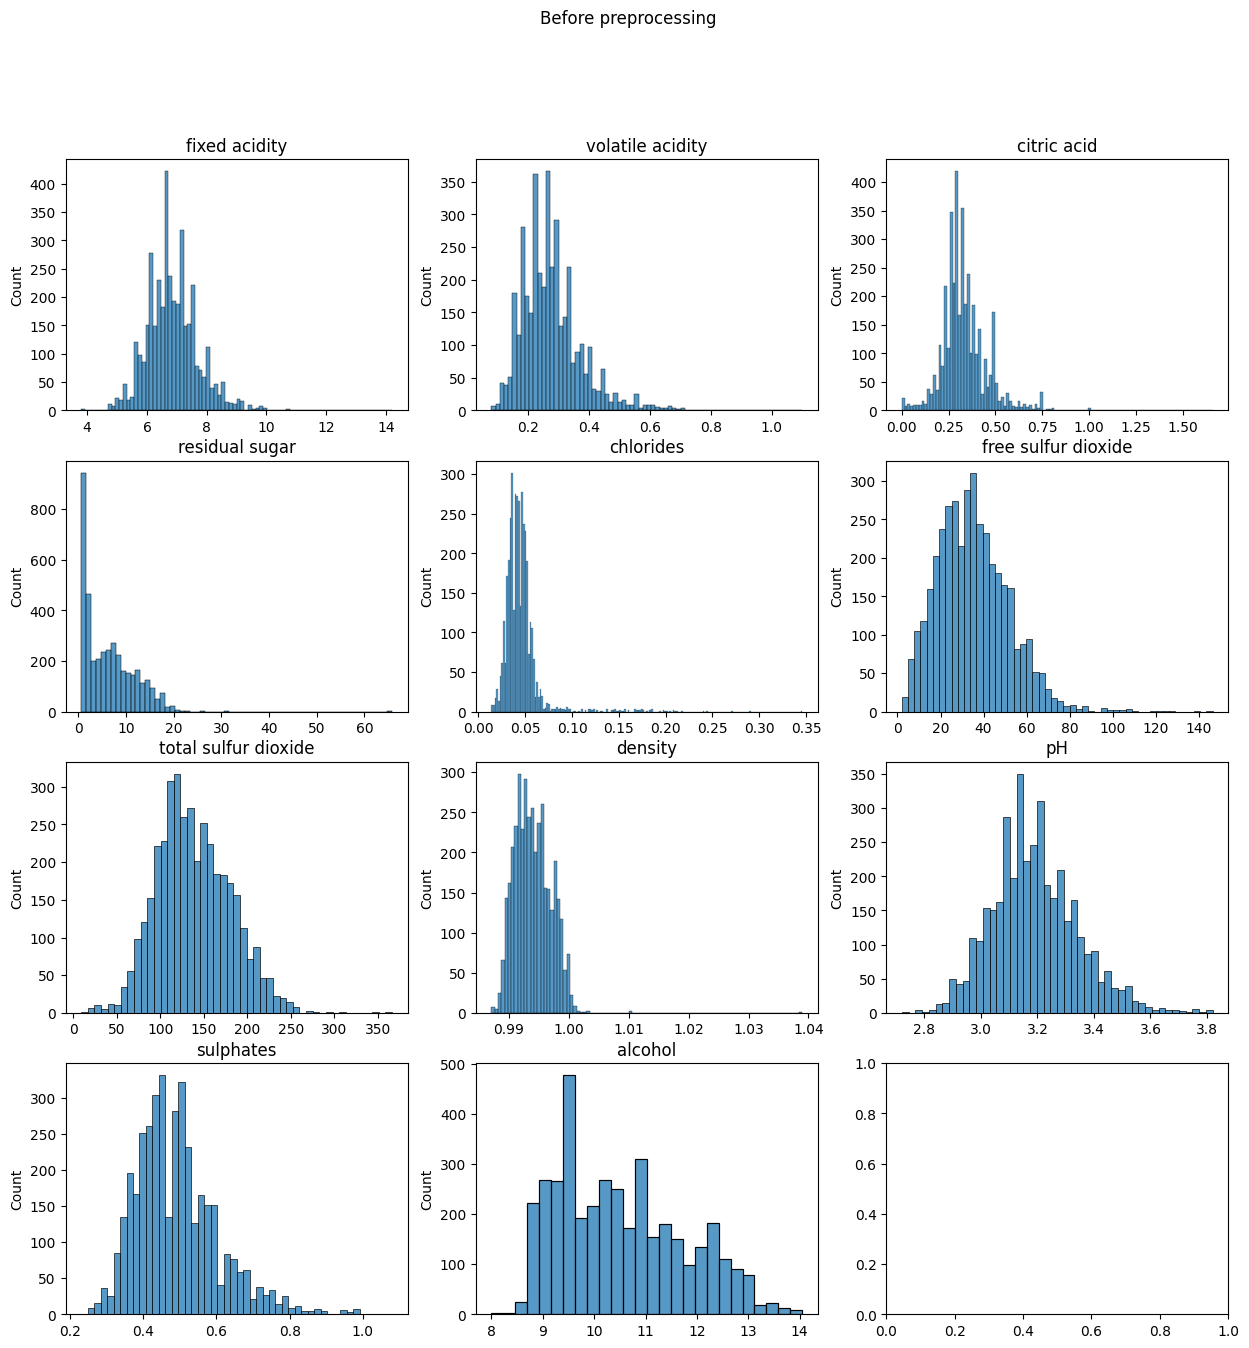

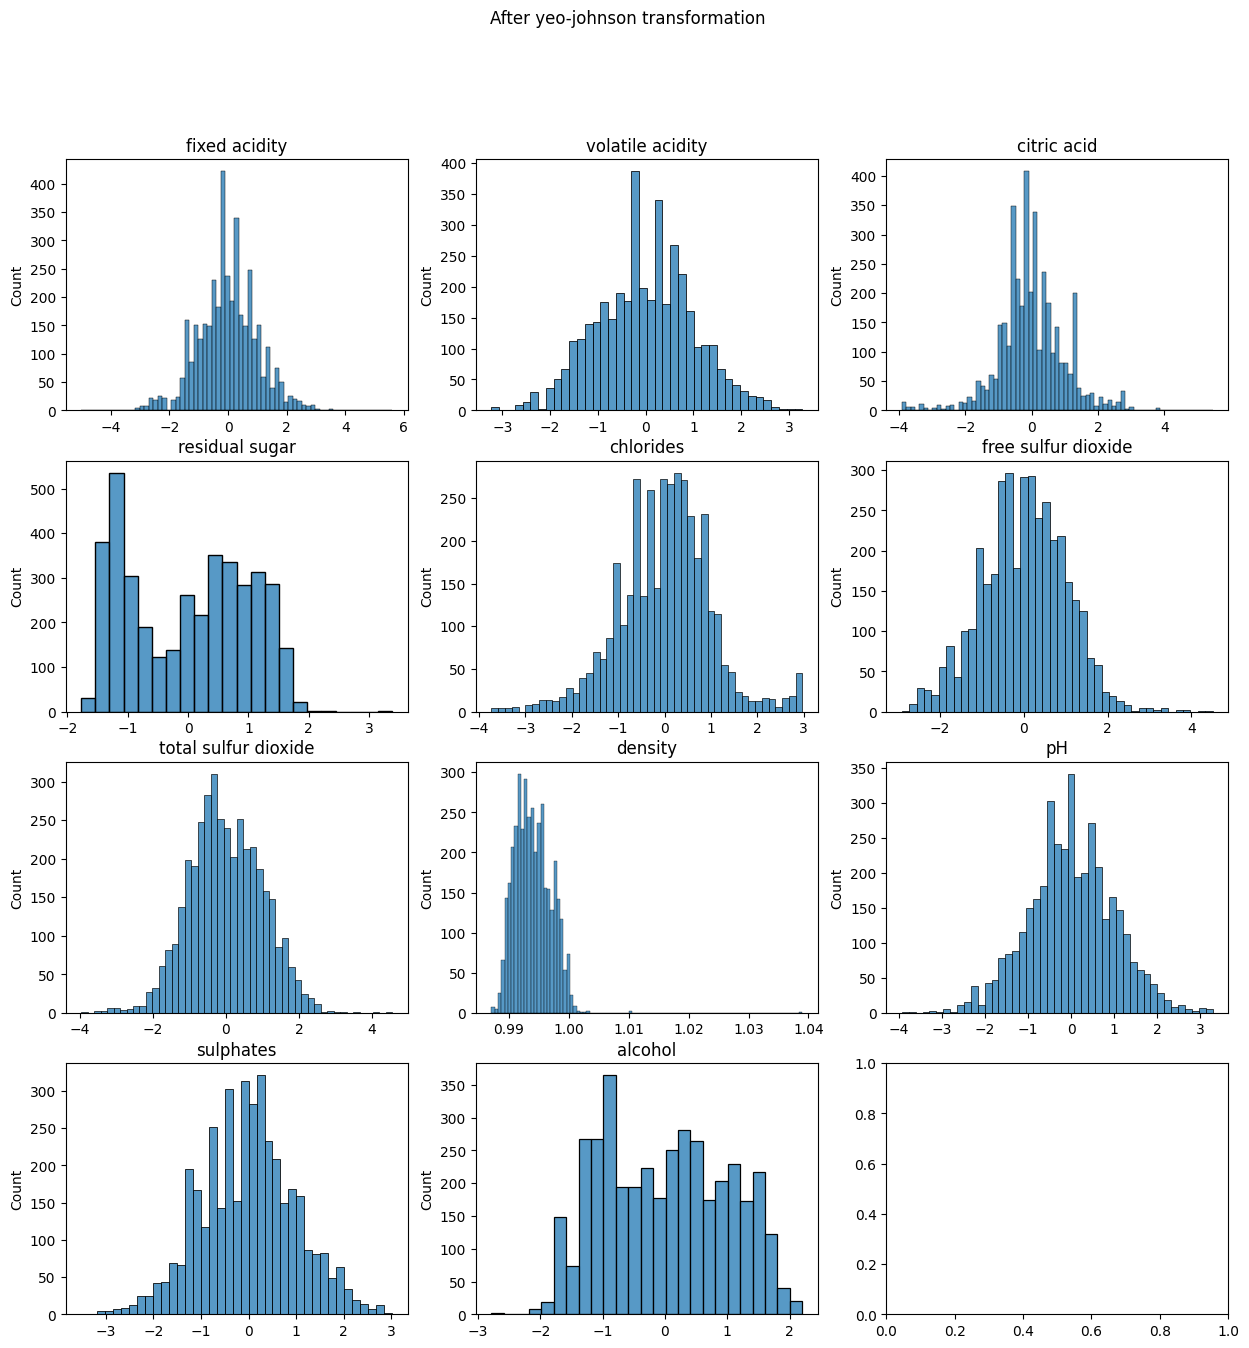

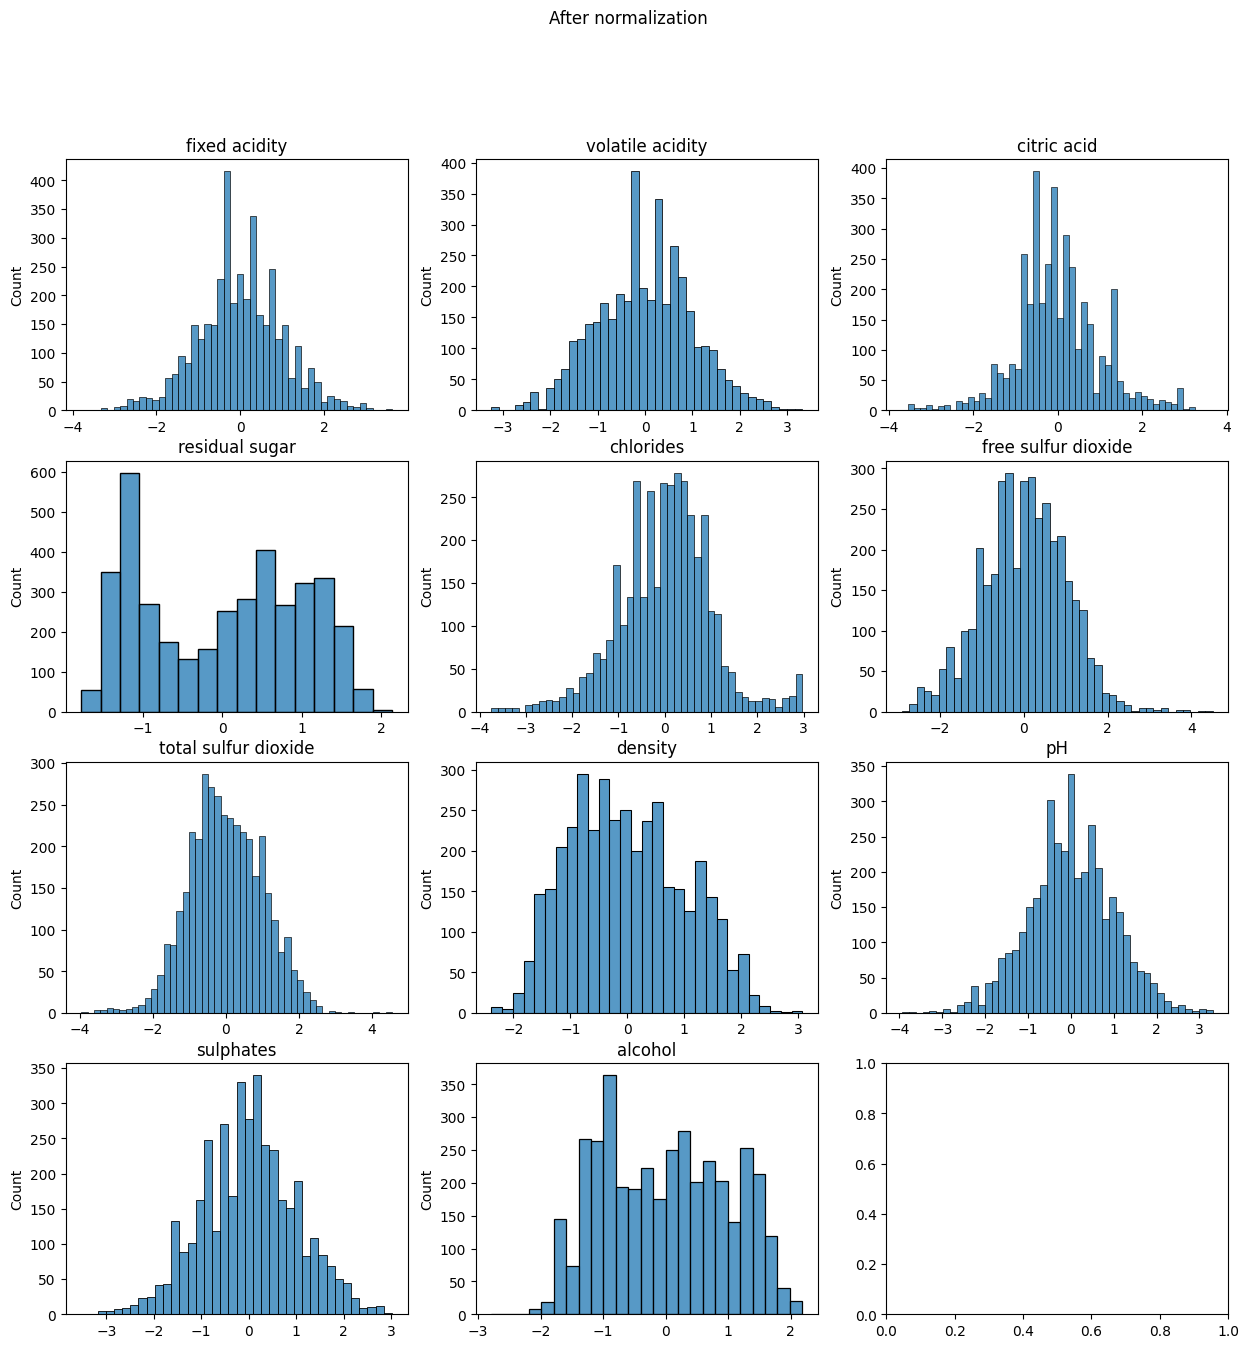

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 151/151 [00:01<00:00, 130.93it/s, loss=0.412, v_num=394, train_loss_step=0.405, val_loss=0.640, val_epoch_loss=0.461, train_loss_epoch=0.404, train_epoch_loss=0.404]


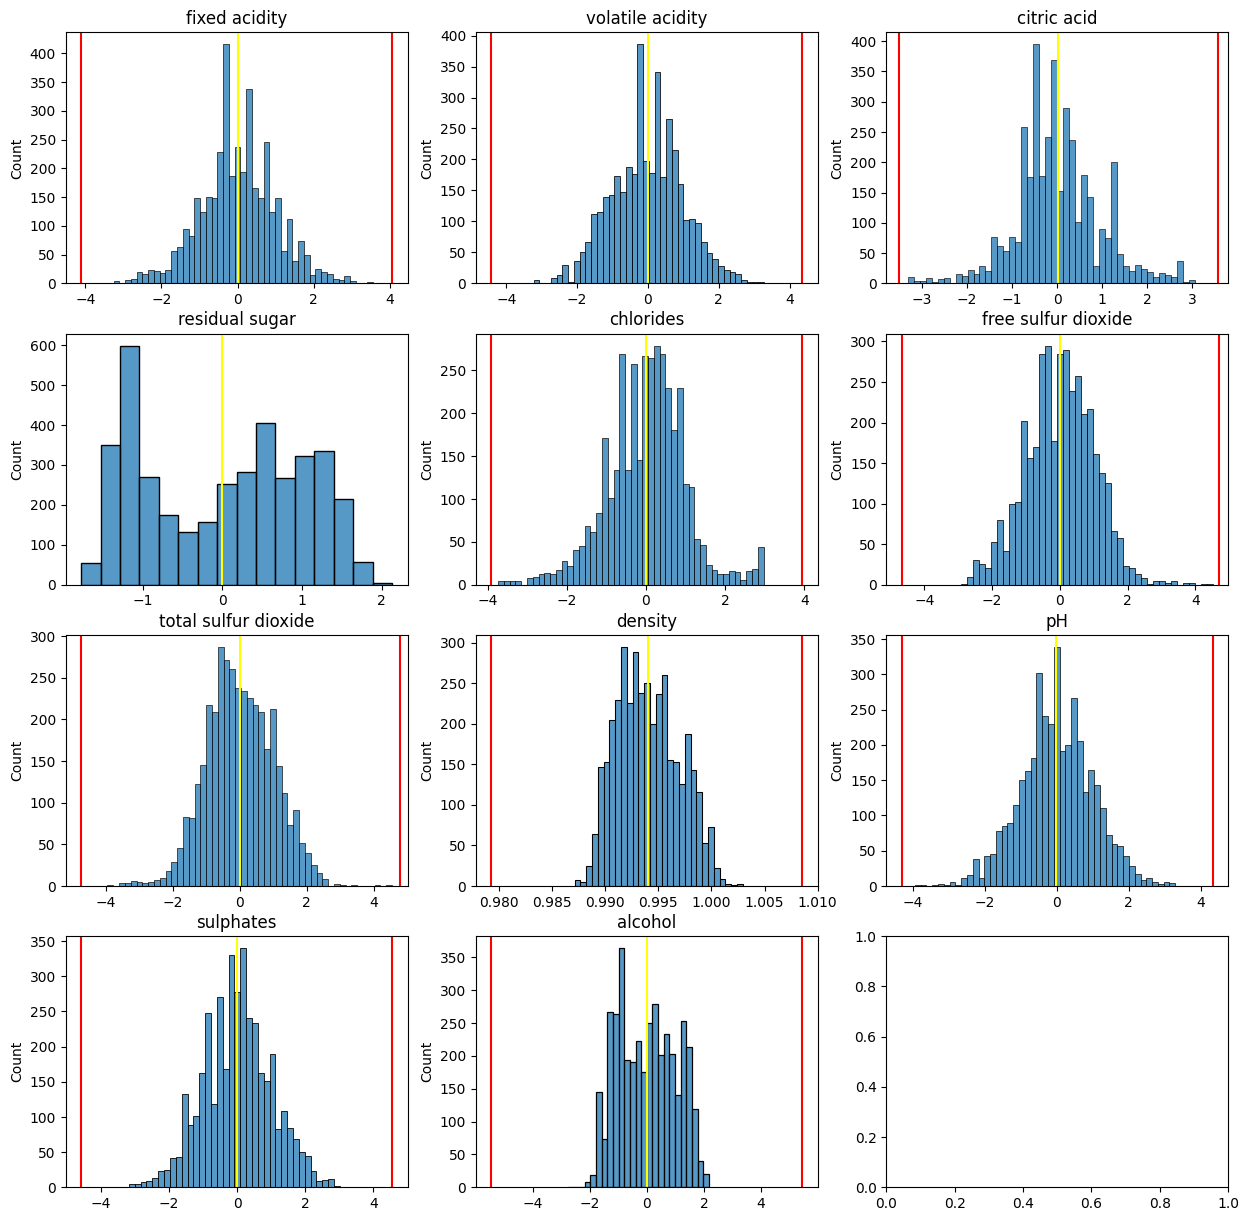

Accuracy: 78.96%


In [23]:
iqr_threshold = study.best_params["iqr_threshold"]
iqr_thresholds = np.ones(11) * iqr_threshold
l2_lambda = study.best_params["l2_lambda"]  

torch.manual_seed(seed)
data = WineData(
    batch_size=batch_size,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    iqr_thresholds=iqr_thresholds,
    remove_outliers=True,
    viz=True,
)
model = WineModel(hidden_size=hidden_size, lr=lr, l2_lambda=l2_lambda)
logger = TensorBoardLogger("logs", name="wine")
monitor = "val_MulticlassAccuracy_epoch"
early_stopping = EarlyStopping(monitor=monitor, mode="max", patience=5)
model_checkpoint = ModelCheckpoint(monitor=monitor, mode="max", save_top_k=3, save_last=True)
trainer = pl.Trainer(
    max_epochs=epochs,
    logger=logger,
    callbacks=[early_stopping, model_checkpoint],
    accelerator="cuda",
    devices=1,
)
trainer.fit(model, data)
data.plot()
print(f"Accuracy: {trainer.checkpoint_callback.best_model_score.item()*100:.2f}%")